# Instrumental Variable Modelling (IV) with `pymc` models

This notebook shows an example of using instrumental variable regression. We will follow an example from Acemoglu, Johnson and Robinson (2001) which attempted to disentangle the effect of robust political institutions on economic productivity measured in GDP terms. This notebook example draws on the discussion in {cite:t}`hansenEconometrics` and {cite:t}`acemoglu2001colonial`

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression as sk_lin_reg

import causalpy as cp
from causalpy.pymc_experiments import ExperimentalDesign, InstrumentalVariable
from causalpy.pymc_models import (
    InstrumentalVariableRegression,
    LinearRegression,
    ModelBuilder,
)

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

The idea of this work was to look at the different outcomes in `loggdp` terms for various colonised countries as a function of a measure of the robustness of political institutions measured as: `risk`. This latter variable is a score for the legal protection available against expropriation of property. The higher the score, the more legal protection available. The thought is that legal and political institutional structures have long-lasting benefits and since the colonies were treated differently under different colonial powers (with varying degree of institutional development), the argument is that we can potentially estimate the effects of political institution on GDP with this kind of data. 

In a picture:

![IV Regression](../_static/iv_reg1.png)

Here the $X$ covariates contain a treatment variable (`risk`) which is correlated with the outcome $Y$ (`loggdp`) through the intermediating values of $H$ (unmeasured history) violating the OLS assumptions of independence. The idea is to recover the unbiased treatment effect of risk by invoking $Z$ our instrument(s) `logmort0` which is assumed to be correlated with $Y$ only through its influence on $X$. 


This relatively simple graph occurs quite commonly in the context of policy adoption, where we're interested in the effect of some treatment/policy $X_{t}$ on a population, where $Z$ is some measure that influences adoption. In a medical context the first stage $X \sim 1 +  \beta Z$ is referred to as the "intent-to-treat" regression. Because of this relation to policy implementation such instrumental variable regression are often quite useful in industry.

We will now show concretely how we can estimate these type of regressions in `CausalPy` to recover accurate parameters in a situation characterised by this DAG. 


In [3]:
N = 100
e1 = np.random.normal(0, 3, N)
e2 = np.random.normal(0, 1, N)
Z = np.random.uniform(0, 1, N)
## Ensure the endogeneity of the the treatment variable
X = -1 + 4 * Z + e2 + 2 * e1
y = 2 + 3 * X + 3 * e1

test_data = pd.DataFrame({"y": y, "X": X, "Z": Z})

sample_kwargs = {
    "tune": 1000,
    "draws": 2000,
    "chains": 4,
    "cores": 4,
    "target_accept": 0.99,
}
instruments_formula = "X  ~ 1 + Z"
formula = "y ~  1 + X"
instruments_data = test_data[["X", "Z"]]
data = test_data[["y", "X"]]
iv = InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
)

/Users/nathanielforde/Documents/Github/CausalPy/causalpy/pymc_experiments.py:981: UserWarning: Warning. The treatment variable is not Binary. 
 
                          This is not necessarily a problem but it complicates 

                          the interpretation of the model coefficients.
  warnings.warn("""Warning. The treatment variable is not Binary. \n
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_t, beta_z, chol_cov]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 96 seconds.
Sampling: [beta_t, beta_z, chol_cov, likelihood]
Sampling: [likelihood]


In [4]:
az.summary(iv.model.idata, var_names=["beta_t", "beta_z"])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

,mean,sd,hdi_3%,hdi_97%,r_hat
beta_t[Intercept],-2.551,0.567,-3.581,-1.479,1.0
beta_t[Z],7.877,0.804,6.323,9.375,1.0
beta_z[Intercept],1.488,0.361,0.811,2.169,1.0
beta_z[X],3.756,0.100,3.571,3.944,1.0


Where we can see the `beta_z` parameter against the X variable is close to the true value 3. 

### Comparison to OLS



In [5]:
simple_ols_reg = sk_lin_reg().fit(X.reshape(-1, 1), y)

print("Intercept:", simple_ols_reg.intercept_, "Beta:", simple_ols_reg.coef_[0])

Intercept: 0.6042943951345823 Beta: 4.3426604220834735


We can see here how OLS overestimates the values of the focal parameters due to the endogeneity of the treatment variable and the IV regression is much closer to the truth. It is this kind of bias that the instrumental variable design is supposed to mitigate. 

## Applying the Theory: Political Institutions and GDP

Reminder, we want to model the following relationship: 

![IV Regression](../_static/iv_reg2.png)

We load the data as follows:

In [6]:
iv_df = cp.load_data("risk")
iv_df[["longname", "loggdp", "risk", "logmort0"]].head()

,longname,loggdp,risk,logmort0
0,Angola,7.77,5.36,5.634790
1,Argentina,9.13,6.39,4.232656
2,Australia,9.90,9.32,2.145931
3,Burkina Faso,6.85,4.45,5.634790
4,Bangladesh,6.88,5.14,4.268438


The complication emerges when we observe that political institutions are **engodgenous** in the system which lead to that growth. So we need to control in some way for measurement error and bias we could expect if we fit a simple OLS model. They continue to argue that we can use an instrumental variable which is correlated with GDP only through the degree of political institutions by using instrumental variable regression. They ultimately suggest using mortality rates faced by European settlers in the period as an instrument, because higher mortality rates will lead to less migration and investment in the area which should see a reduction in the political institutions established in the colonies. They could gather this data using military records. 

We can manually estimate the 2SLS (Two stage least squares) estimate for the treatment effect of `risk` as follows: 

In [7]:
X = iv_df.risk.values.reshape(-1, 1)
Z = iv_df.logmort0.values.reshape(-1, 1)
t = iv_df.risk.values
y = iv_df.loggdp.values

simple_ols_reg = sk_lin_reg().fit(X, y)
first_stage_reg = sk_lin_reg().fit(Z, t)
fitted_risk_values = first_stage_reg.predict(Z)


second_stage_reg = sk_lin_reg().fit(X=fitted_risk_values.reshape(-1, 1), y=y)

print(
    "Simple OLS Parameters: Intercept and Beta Coeff",
    simple_ols_reg.intercept_,
    simple_ols_reg.coef_,
)
print(
    "First Stage Parameters: Intercept and Beta Coeff",
    first_stage_reg.intercept_,
    first_stage_reg.coef_,
)
print(
    "Second Stage Parameters Intercept and Beta Coeff",
    second_stage_reg.intercept_,
    second_stage_reg.coef_,
)

Simple OLS Parameters: Intercept and Beta Coeff 4.687414702305412 [0.51618698]
First Stage Parameters: Intercept and Beta Coeff 9.365894904697788 [-0.61328925]
Second Stage Parameters Intercept and Beta Coeff 1.9942956864448975 [0.92948966]


Note the significant differences between the naive OLS estimate `0.515` and the 2SLS estimate of `0.92` on the treatment effect. This accords with the results reported in the paper. 

In this notebook we will not further discuss the issues around weak and strong instrumental variables, how to find and test the strength of instruments, but we will demonstrate how to fit these types of models in the Bayesian setting. We will also discuss how the Bayesian approach under hood models both the focal (second stage) and the instrumental (first stage) regression as a multivariate random variable with explicit correlations. The idea is to model both outcomes together with explicit correlations. The benefit of this approach is the extra insight we get into the relationship between the "instrument" and the outcome.

\begin{align*}
\left(
\begin{array}{cc}
y \\
t
\end{array}
\right)
& \sim
\text{MultiNormal}(\mu, \Sigma) \\
\mu & = \left(
\begin{array}{cc}
\mu_{y} \\
\mu_{t}
\end{array}
\right)
=
\left(
\begin{array}{cc}
\beta_{00} + \beta_{01}t \\
\beta_{10} + \beta_{11}z
\end{array}
\right)
\end{align*}


In this choice of implementation we follow the example of Juan Orduz's [blog](https://juanitorduz.github.io/iv_pymc/) which in turn draws upon Jim Savage's [work](https://khakieconomics.github.io/2017/11/26/Bayesian_iv.html). It has the benefit of crystallising and explicitly characterising the fact that we're interested in the joint distribution of the treatment and the instrument. 

## Fitting the Model: The Bayesian Way

We invoke `CausalPy` for our data as follows:

/Users/nathanielforde/Documents/Github/CausalPy/causalpy/pymc_experiments.py:981: UserWarning: Warning. The treatment variable is not Binary. 
 
                          This is not necessarily a problem but it complicates 

                          the interpretation of the model coefficients.
  warnings.warn("""Warning. The treatment variable is not Binary. \n
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_t, beta_z, chol_cov]


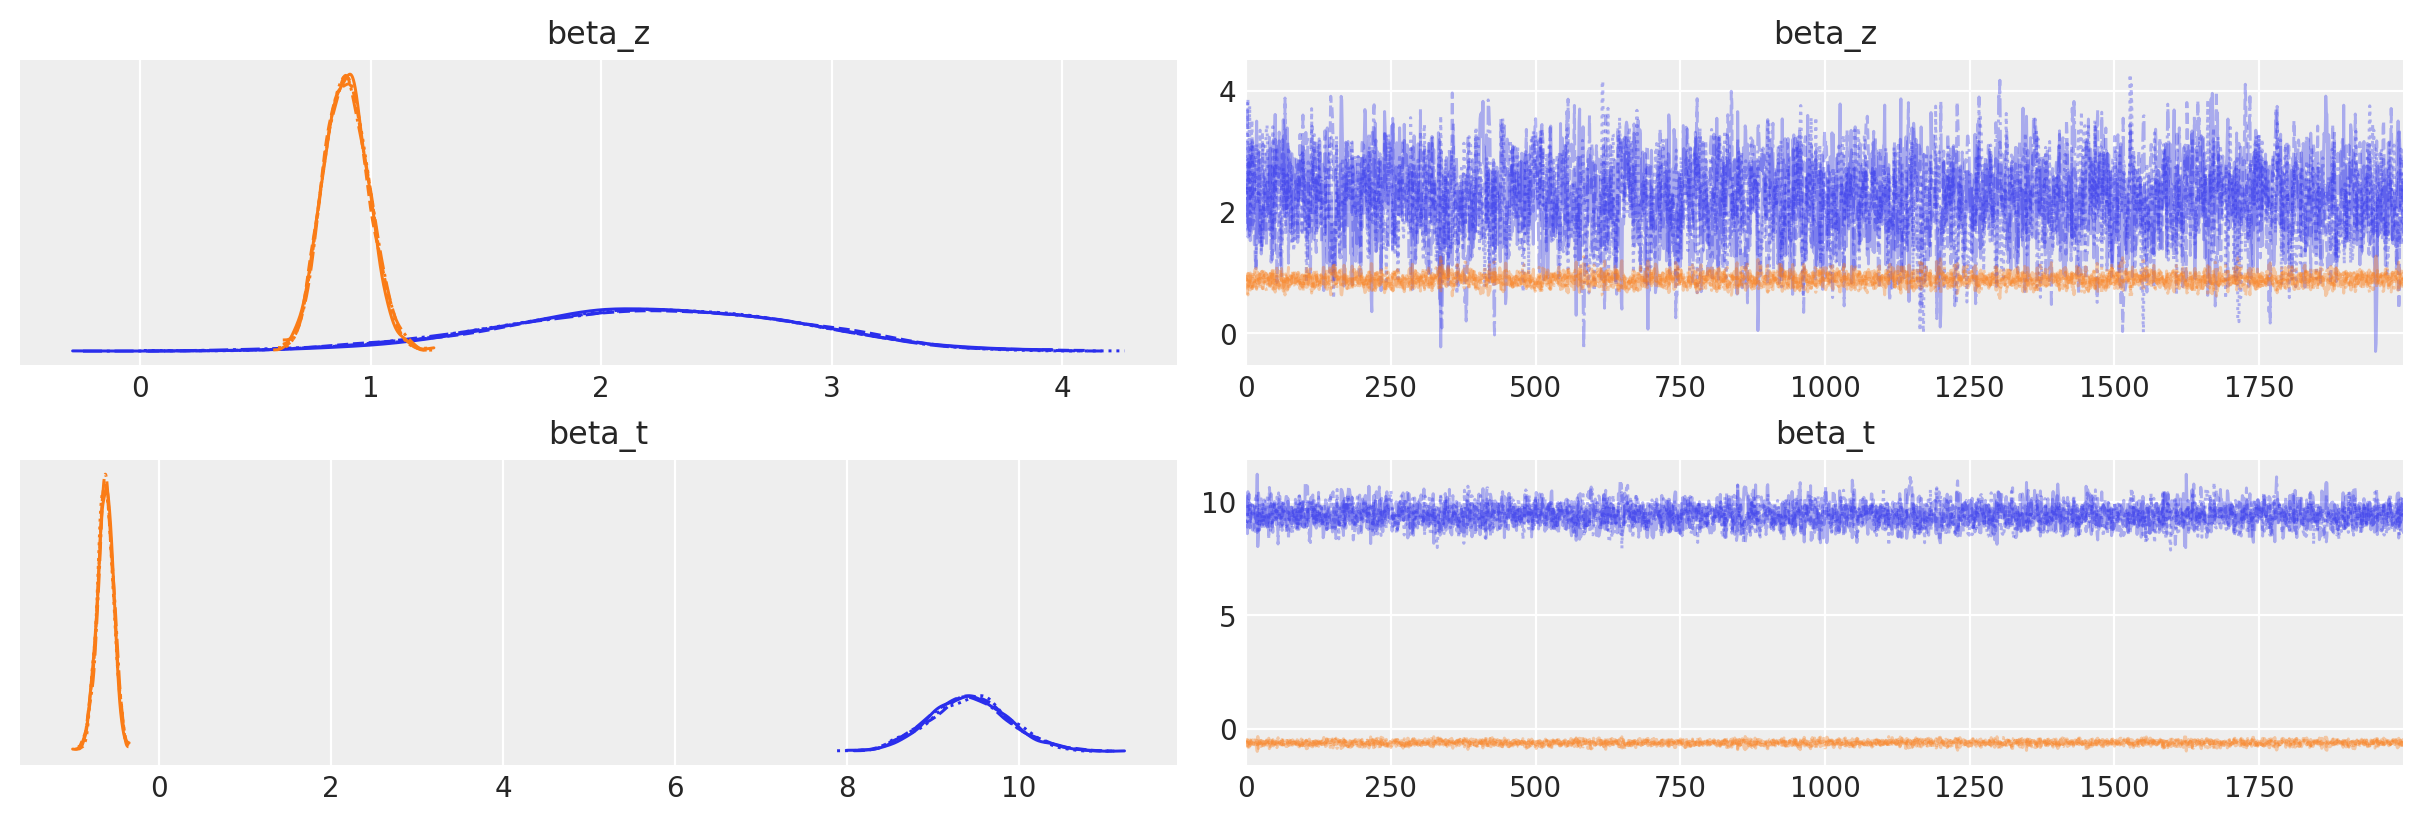

In [8]:
sample_kwargs = {"tune": 1000, "draws": 2000, "chains": 4, "cores": 4}
instruments_formula = "risk  ~ 1 + logmort0"
formula = "loggdp ~  1 + risk"
instruments_data = iv_df[["risk", "logmort0"]]
data = iv_df[["loggdp", "risk"]]
# priors = {"mus": [[10, 0], [2, 0]], "sigmas": [[1, 1], [1, 1]]}
iv = InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
)


az.plot_trace(iv.model.idata, var_names=["beta_z", "beta_t"]);

The diagnostic plots show good convergence and the parameters of primary interest are the beta parameters on the `risk` variable here, which agrees quite closely with the MLE fits we saw earlier using two stage least squares. 

In [9]:
az.summary(iv.model.idata, var_names=["beta_t", "beta_z"])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

,mean,sd,hdi_3%,hdi_97%,r_hat
beta_t[Intercept],9.430,0.461,8.577,10.321,1.0
beta_t[logmort0],-0.627,0.095,-0.806,-0.446,1.0
beta_z[Intercept],2.215,0.641,1.027,3.403,1.0
beta_z[risk],0.895,0.097,0.723,1.083,1.0


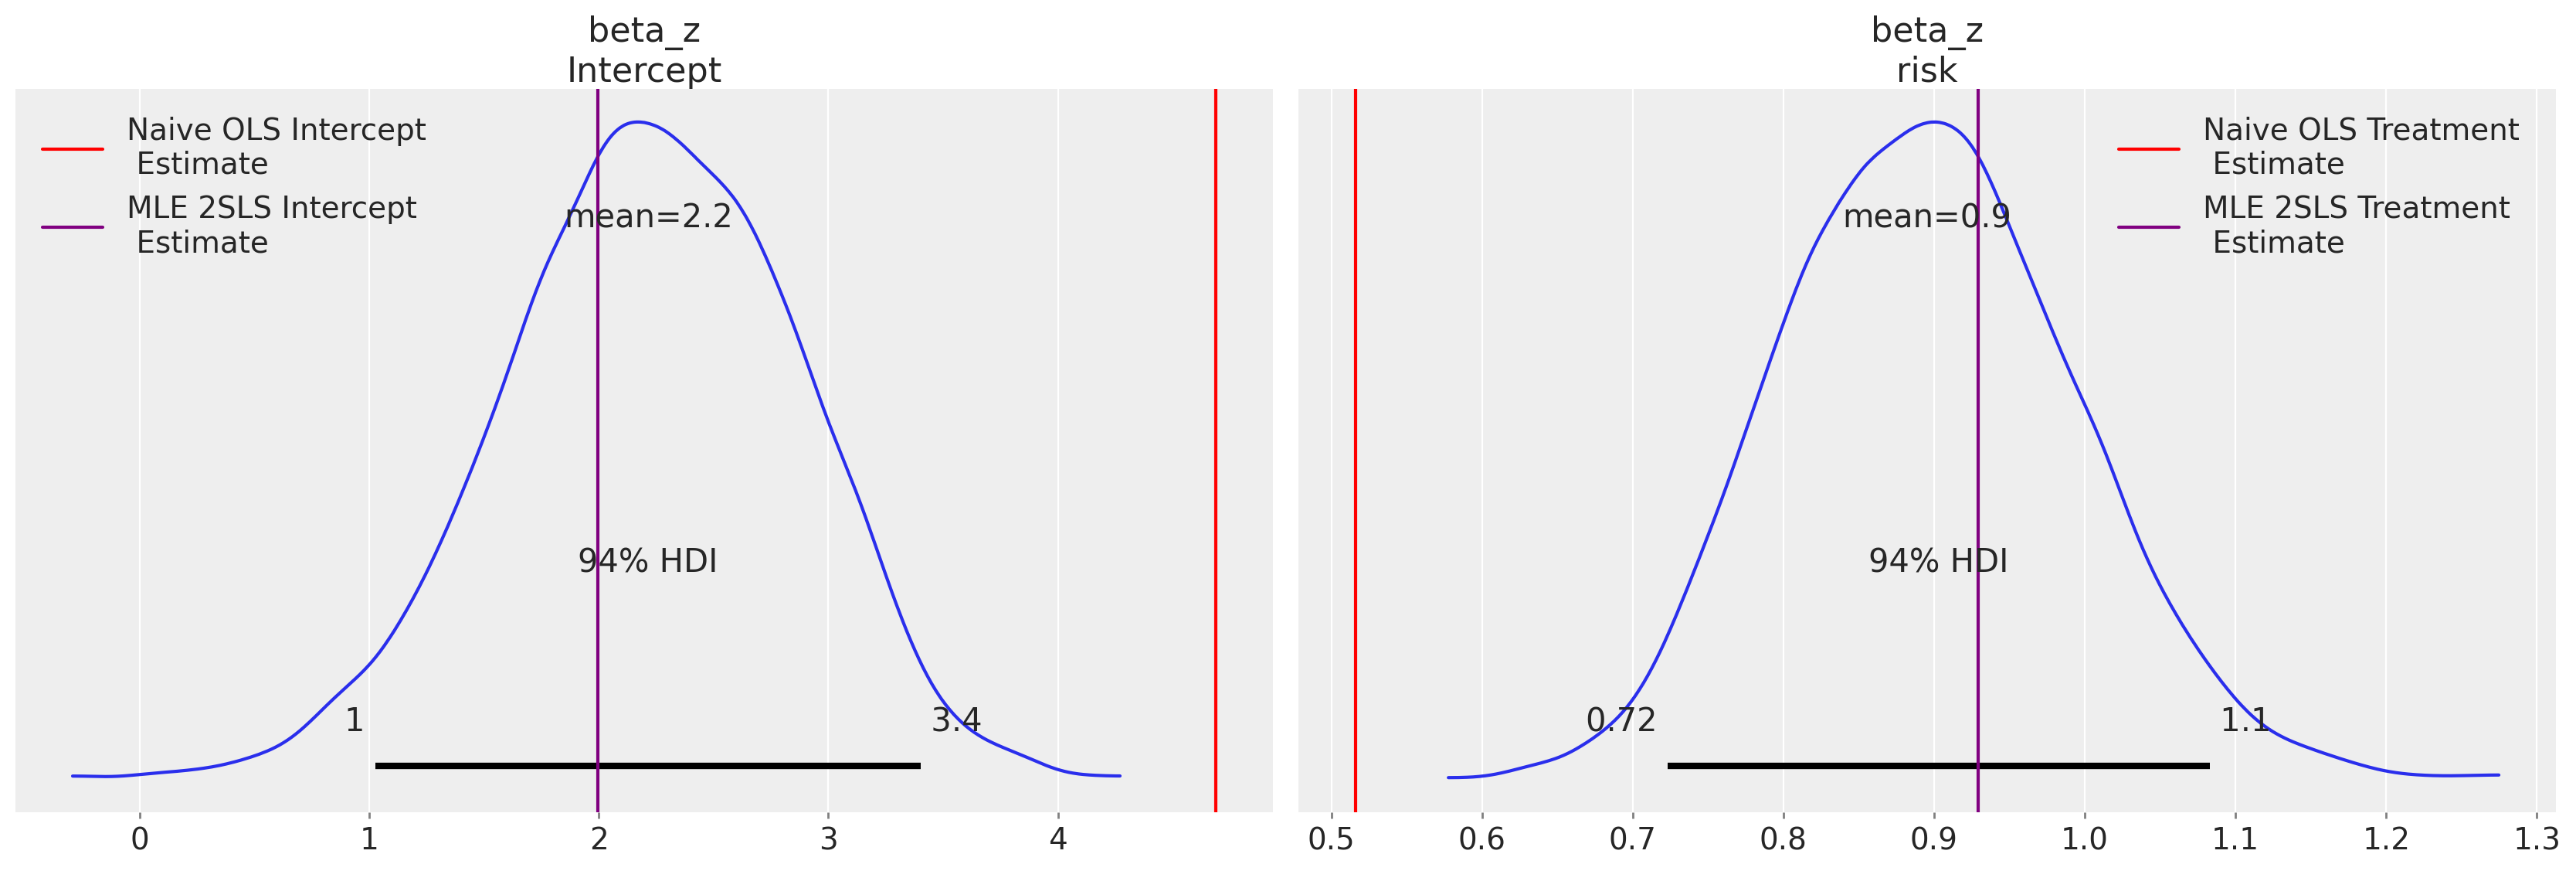

In [10]:
hdi_prob = 0.94
ax = az.plot_posterior(
    data=iv.model.idata,
    var_names=["beta_z"],
    hdi_prob=hdi_prob,
)

ax[0].axvline(
    iv.ols_beta_params["Intercept"],
    label="Naive OLS Intercept \n Estimate",
    color="red",
)
ax[1].axvline(
    iv.ols_beta_params[iv.instrument_variable_name],
    label="Naive OLS Treatment \n Estimate",
    color="red",
)
ax[0].axvline(
    iv.ols_beta_second_params[0], label="MLE 2SLS Intercept \n Estimate", color="purple"
)
ax[1].axvline(
    iv.ols_beta_second_params[1], label="MLE 2SLS Treatment \n Estimate", color="purple"
)
ax[0].legend()
ax[1].legend();

### Multivariate Outcomes and Measures of Correlation

As we stated above, one of the benefits of the Bayesian approach is that we directly measure the bivariate relationship between the instrument and the treatment. We can see (in two dimensions) a representation of how the difference in the estimated treatment coefficients skews the expected outcomes. 

In [11]:
az.summary(iv.model.idata, var_names=["chol_cov_corr"])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,r_hat
"chol_cov_corr[0, 0]",1.000,0.000,1.000,1.000,NaN
"chol_cov_corr[0, 1]",-0.696,0.091,-0.853,-0.524,1.0
"chol_cov_corr[1, 0]",-0.696,0.091,-0.853,-0.524,1.0
"chol_cov_corr[1, 1]",1.000,0.000,1.000,1.000,1.0


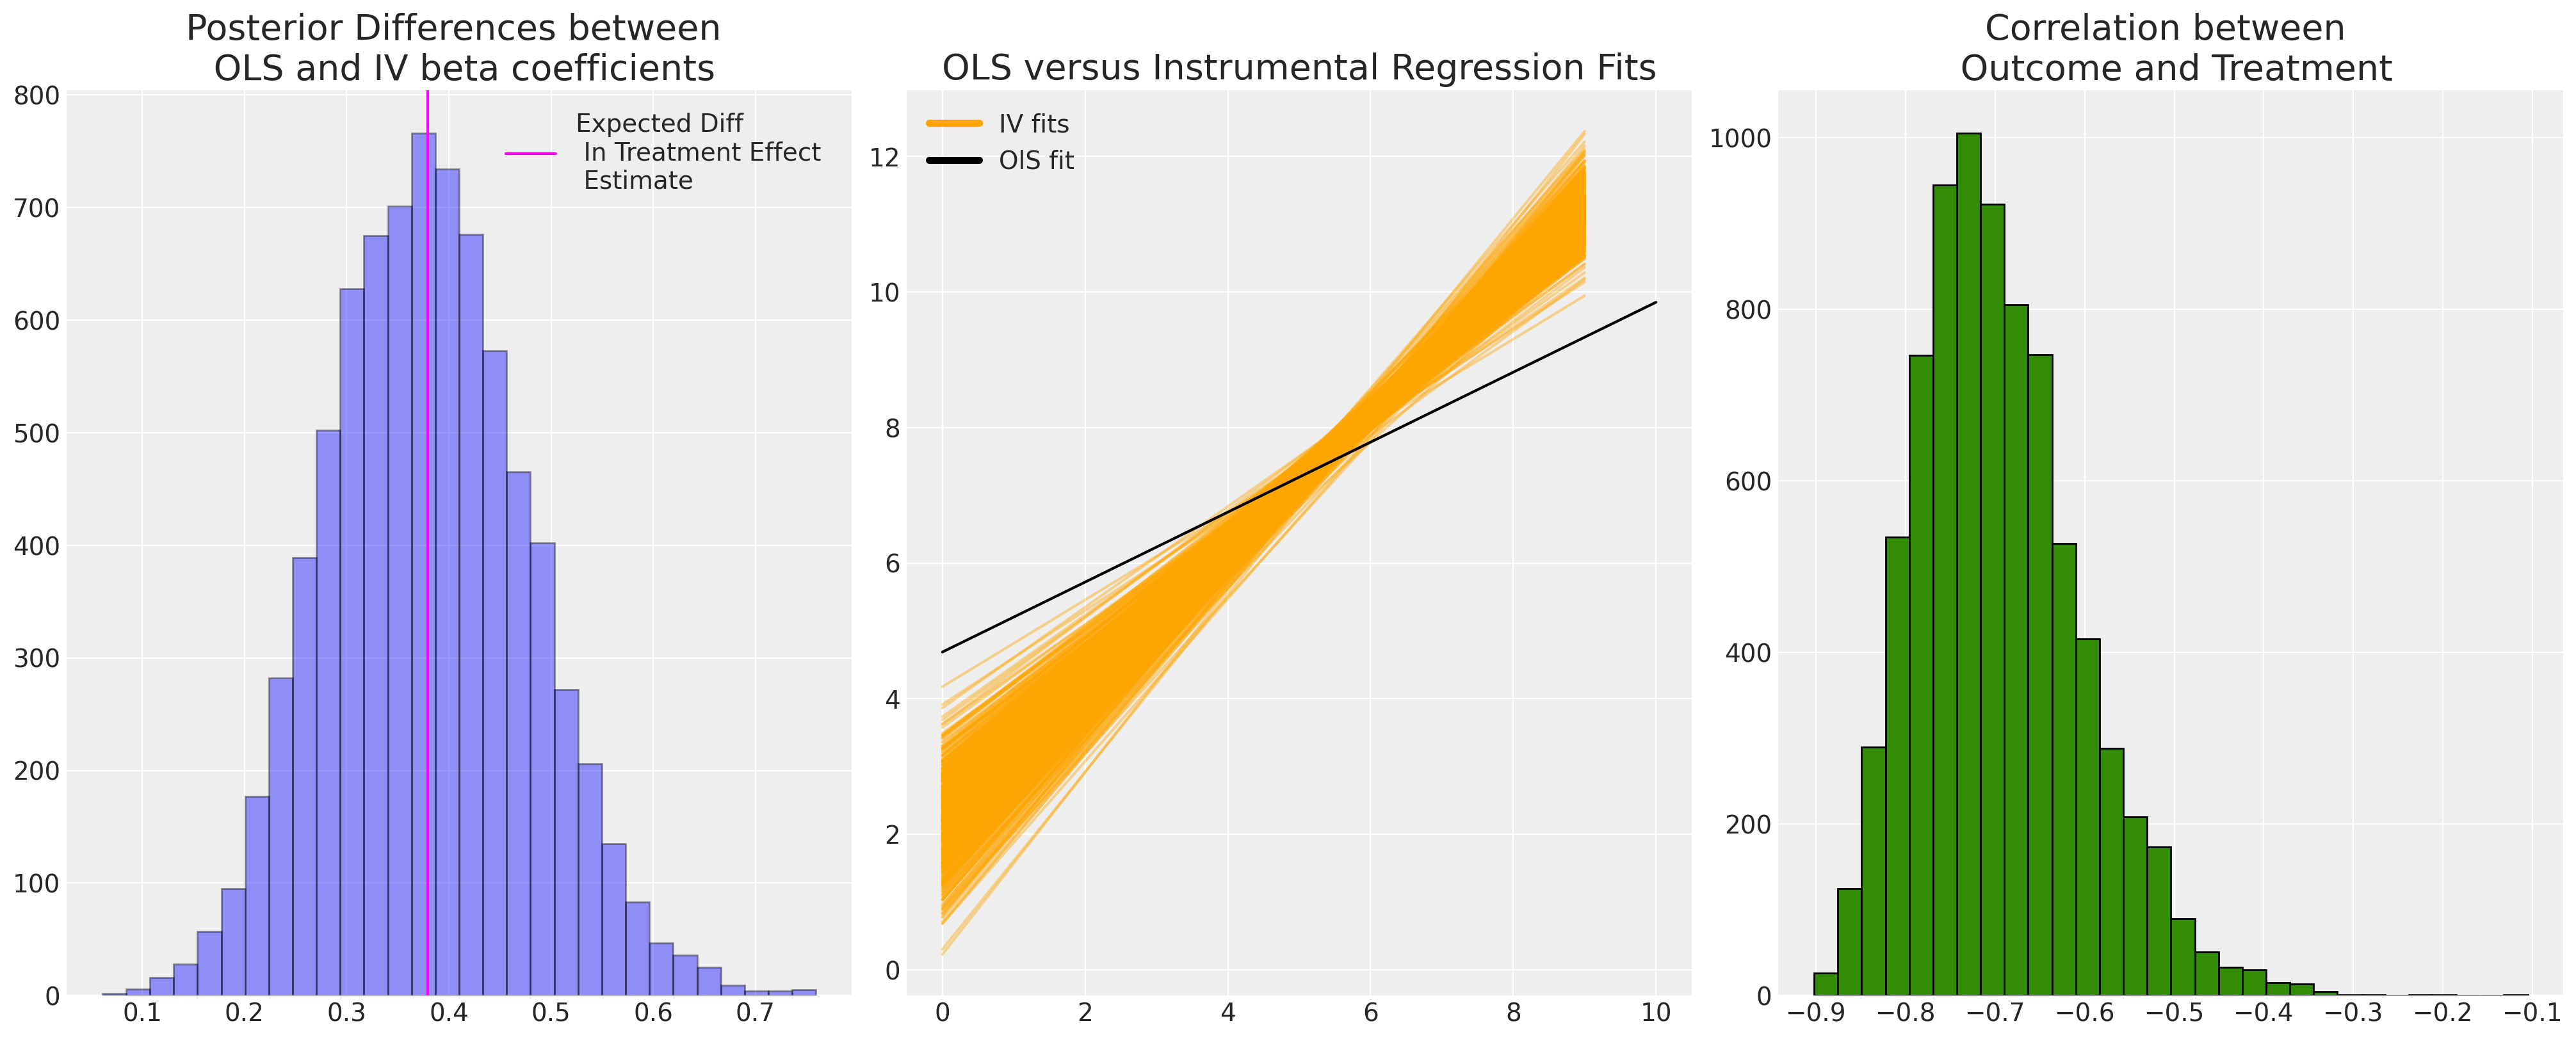

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

diffs = (
    iv.model.idata["posterior"]["beta_z"].sel(covariates=[iv.instrument_variable_name])
    - iv.ols_beta_params[iv.instrument_variable_name]
)
axs[0].hist(diffs.values.flatten(), bins=30, ec="black", color="blue", alpha=0.4)
axs[0].axvline(
    np.mean(diffs.values.flatten()),
    label="Expected Diff \n In Treatment Effect \n Estimate",
    color="magenta",
)
axs[0].legend()

intercepts = iv.model.idata["posterior"]["beta_z"].sel(covariates=["Intercept"])
betas = iv.model.idata["posterior"]["beta_z"].sel(
    covariates=[iv.instrument_variable_name]
)


raw_df = pd.DataFrame(iv.X, columns=iv.labels)
x = np.linspace(0, 10, 10)
uncertainty = [intercepts.values.flatten() + betas.values.flatten() * i for i in x]
uncertainty = pd.DataFrame(uncertainty).T

ols = [
    iv.ols_beta_params["Intercept"]
    + iv.ols_beta_params[iv.instrument_variable_name] * i
    for i in x
]

custom_lines = [
    Line2D([0], [0], color="orange", lw=4),
    Line2D([0], [0], color="black", lw=4),
]

uncertainty.sample(500).T.plot(legend=False, color="orange", alpha=0.4, ax=axs[1])
axs[1].plot(x, ols, color="black", label="OLS fit")
axs[1].set_title("OLS versus Instrumental Regression Fits", fontsize=20)
axs[1].legend(custom_lines, ["IV fits", "OlS fit"])

axs[0].set_title(
    "Posterior Differences between \n OLS and IV beta coefficients", fontsize=20
)

corr = az.extract(data=iv.model.idata, var_names=["chol_cov_corr"])[0, 1, :]
axs[2].hist(corr, bins=30, ec="black", color="C2", label="correlation")
axs[2].set_title("Correlation between \n Outcome and Treatment", fontsize=20);

## Conclusion 

What we see here is that there are non-trivial differences in the manner in which we estimate the effects of different policy interventions. Instrumental variable regression is one tool in our kit to tease out the subtle effects of policy in a situation potentially confounded in the manner described by the fundamental DAG above. 

Like other techniques in causal inference, allot hinges on how plausible the initial DAG is for your circumstances and whether the nature of the confounding can be addressed by the technique. Instrumental variable regressions are popular and foundational in econometrics largely because the underlying pattern of confounding is so prevalent where we wish to examine the effect of policy interventions. 

## References
:::{bibliography}
:filter: docname in docnames
:::